In [1]:
import numpy as np
from matplotlib import pyplot as plt

import jax.numpy as jnp
from jax import random, lax, jit, vmap

import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoBNAFNormal, AutoIAFNormal
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_value
from numpyro.infer.reparam import NeuTraReparam

In [2]:
# Load data
lc = np.loadtxt("lc.txt")
interp = np.loadtxt("interp.txt")
t, F, Ferr = lc
points, zeta_e, zeta_n, zeta_e_dot, zeta_n_dot = interp

In [3]:
def model(t, F, Ferr):
    ln_DeltaF = numpyro.sample("ln_DeltaF", dist.Normal(4.0, 4.0))
    DeltaF = jnp.exp(ln_DeltaF)
    ln_Fbase = numpyro.sample("ln_Fbase", dist.Normal(2.0, 4.0))
    Fbase = jnp.exp(ln_Fbase)
    t0 = numpyro.sample("t0", dist.Normal(3630.0, 50.0))
    ln_tE = numpyro.sample("ln_tE", dist.Normal(3.0, 6.0))
    tE = jnp.exp(ln_tE)
    u0 = numpyro.sample("u0", dist.Normal(0.0, 1.0))
    piEE = numpyro.sample("piEE", dist.Normal(0.0, 0.5))
    piEN = numpyro.sample("piEN", dist.Normal(0.0, 0.5))

    # Compute trajectory
    zeta_e_t = jnp.interp(t, points, zeta_e)
    zeta_n_t = jnp.interp(t, points, zeta_n)
    zeta_e_t0 = jnp.interp(t0, points, zeta_e)
    zeta_n_t0 = jnp.interp(t0, points, zeta_n)
    zeta_e_dot_t0 = jnp.interp(t0, points, zeta_e_dot)
    zeta_n_dot_t0 = jnp.interp(t0, points, zeta_n_dot)

    delta_zeta_e = zeta_e_t - zeta_e_t0 - (t - t0) * zeta_e_dot_t0
    delta_zeta_n = zeta_n_t - zeta_n_t0 - (t - t0) * zeta_n_dot_t0

    u_per = u0 + piEN * delta_zeta_e - piEE * delta_zeta_n
    u_par = (t - t0) / tE + piEE * delta_zeta_e + piEN * delta_zeta_n
    u = jnp.sqrt(u_per ** 2 + u_par ** 2)

    # Magnification
    A_u = (u ** 2 + 2) / (u * jnp.sqrt(u ** 2 + 4))
    A_u0 = (u0 ** 2 + 2) / (jnp.abs(u0) * jnp.sqrt(u0 ** 2 + 4))
    A = (A_u - 1) / (A_u0 - 1)
    F_pred = DeltaF * A + Fbase

    ln_c = numpyro.sample("ln_c", dist.Exponential(1 / 2.0))

    return numpyro.sample("data_dist", dist.Normal(F_pred, jnp.exp(ln_c) * Ferr), obs=F)

## NUTS

In [4]:
init_vals = {
    "ln_DeltaF": np.log(250),
    "ln_Fbase": np.log(188),
    "t0": 3630.0,
    "ln_tE": 3.1,
    "u0": 0.5,
}

nuts_kernel = NUTS(
    model,
    dense_mass=True,
    target_accept_prob=0.95,
    init_strategy=init_to_value(values=init_vals),
)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, t, F, Ferr)

sample: 100%|██████████| 2500/2500 [00:11<00:00, 214.53it/s, 63 steps of size 6.80e-02. acc. prob=0.96]  


In [5]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  ln_DeltaF      5.58      0.00      5.58      5.57      5.58   2504.67      1.00
   ln_Fbase      5.23      0.00      5.23      5.23      5.23   1794.19      1.00
       ln_c      0.20      0.03      0.20      0.15      0.25   1565.42      1.00
      ln_tE      4.53      0.03      4.53      4.49      4.58   1838.56      1.00
       piEE      0.12      0.01      0.12      0.10      0.14   1680.86      1.00
       piEN      0.30      0.04      0.30      0.22      0.37   1585.67      1.00
         t0   3629.78      0.18   3629.78   3629.47   3630.06   1510.52      1.00
         u0      0.49      0.02      0.49      0.45      0.53   1687.96      1.00

Number of divergences: 0


## Plot likelihood

[Text(0, 0.5, '$\\pi_{EN}$'), Text(0.5, 0, '$u_0$')]

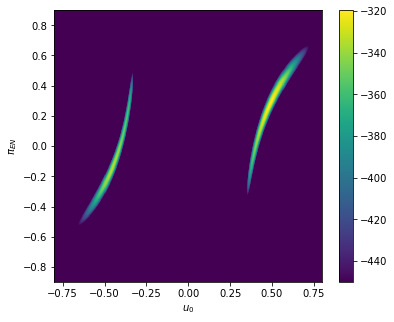

In [6]:
def eval_ll_surface(param="piEN"):
    ln_DeltaF = float(mcmc.get_samples()["ln_DeltaF"][-1])
    DeltaF = jnp.exp(ln_DeltaF)
    ln_Fbase = float(mcmc.get_samples()["ln_Fbase"][-1])
    Fbase = jnp.exp(ln_Fbase)
    t0 = float(mcmc.get_samples()["t0"][-1])
    ln_tE = float(mcmc.get_samples()["ln_tE"][-1])
    tE = jnp.exp(ln_tE)
    piEE = float(mcmc.get_samples()["piEE"][-1])

    piEN_ = jnp.linspace(-0.9, 0.9, 800)
    u0_ = jnp.linspace(-0.8, 0.8, 800)
    u0_grid, piEN_grid = jnp.meshgrid(u0_, piEN_)

    # Compute trajectory
    zeta_e_t = jnp.interp(t, points, zeta_e)
    zeta_n_t = jnp.interp(t, points, zeta_n)
    zeta_e_t0 = jnp.interp(t0, points, zeta_e)
    zeta_n_t0 = jnp.interp(t0, points, zeta_n)
    zeta_e_dot_t0 = jnp.interp(t0, points, zeta_e_dot)
    zeta_n_dot_t0 = jnp.interp(t0, points, zeta_n_dot)

    delta_zeta_e = zeta_e_t - zeta_e_t0 - (t - t0) * zeta_e_dot_t0
    delta_zeta_n = zeta_n_t - zeta_n_t0 - (t - t0) * zeta_n_dot_t0
    ln_c = float(mcmc.get_samples()["ln_c"][-1])

    def eval_ll(u0, piEx):
        u_per = u0 + piEx * delta_zeta_e - piEE * delta_zeta_n
        u_par = (t - t0) / tE + piEE * delta_zeta_e + piEx * delta_zeta_n

        u = jnp.sqrt(u_per ** 2 + u_par ** 2)

        # Magnification
        A_u = (u ** 2 + 2) / (u * jnp.sqrt(u ** 2 + 4))
        A_u0 = (u0 ** 2 + 2) / (jnp.abs(u0) * jnp.sqrt(u0 ** 2 + 4))
        A = (A_u - 1) / (A_u0 - 1)
        F_pred = DeltaF * A + Fbase

        return jnp.sum(-0.5 * (F_pred - F) ** 2 / (jnp.exp(ln_c) * Ferr) ** 2)

    eval_ll_vectorized = jit(vmap(vmap(eval_ll)))

    return u0_grid, piEN_grid, eval_ll_vectorized(u0_grid, piEN_grid)


u0_grid, piEN_grid, ll = eval_ll_surface()

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.pcolormesh(u0_grid, piEN_grid, ll, vmin=-450)
fig.colorbar(im, orientation="vertical")

ax.set(xlabel=r"$u_0$", ylabel=r"$\pi_{EN}$")

## AutoBNAF

In [7]:
# Initialize guide
# Hidden layer i has ``hidden_factors[i]`` hidden units per input dimension (H in the paper)
guide = AutoBNAFNormal(model, num_flows=5, hidden_factors=[25, 25, 25, 25])

schedule = optim.optimizers.polynomial_decay(0.01, 10, 0.001)
svi = SVI(model, guide, optim.Adam(schedule), Trace_ELBO(num_particles=10))
svi_state = svi.init(random.PRNGKey(1), t, F, Ferr)

last_state, losses = lax.scan(
    lambda state, i: svi.update(state, t, F, Ferr), svi_state, jnp.zeros(40000)
)
params = svi.get_params(last_state)

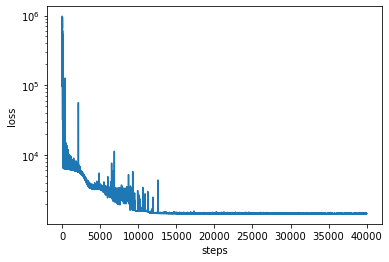

In [8]:
plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("steps")
plt.yscale("log")

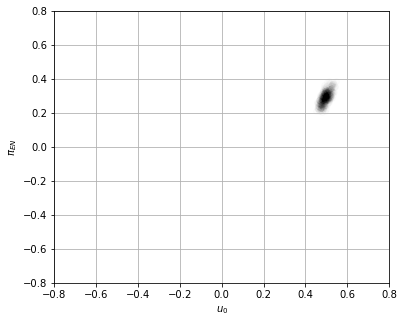

In [9]:
# Get samples from guide
guide_samples = guide.sample_posterior(
    random.PRNGKey(2), params, sample_shape=(500,)
).copy()

fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(guide_samples["u0"], guide_samples["piEN"], color="black", alpha=0.01)
ax.set(xlim=(-0.8, 0.8), ylim=(-0.8, 0.8))
ax.set(xlabel=r"$u_0$", ylabel=r"$\pi_{EN}$")
ax.grid()